In [4]:
import os
import pandas as pd
import numpy as np 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import urllib.request
from collections import Counter
from eunjeon import Mecab
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM , Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot  as plt
import seaborn as sns

In [ ]:
def pickleIO(obj, src, op="r"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj

with open('./data/stopwords-ko.txt', 'r') as s:
    stopwords=  s.readlines()

stopwords = [words.strip() for words in stopwords]

In [5]:
df = pd.DataFrame()
df_all = pickleIO(df, src='./data/df_full.pkl',op='r')
df_train = pickleIO(df, src='./data/df_train.pkl',op='r')
df_valid = pickleIO(df, src='./data/df_valid.pkl',op='r')

df_train.document=  df_train.document.str.replace('[^가-힣]' , ' ')
df_valid.document=  df_valid.document.str.replace('[^가-힣]' , ' ')

df_train.document = df_train.document.str.replace('^ +', '')
df_valid.document = df_valid.document.str.replace('^ +', '')

df_train.document = df_train.document.replace('', np.nan)
df_valid.document = df_valid.document.replace('', np.nan)
df_train  =  df_train.dropna(how='any')
df_valid  =  df_valid.dropna(how='any')
df_train = df_train.drop_duplicates()
df_valid = df_valid.drop_duplicates()
df_train.label = df_train.label.apply(lambda x: 1 if x=='pos' else 0 )
df_valid.label = df_valid.label.apply(lambda x: 1 if x=='pos' else 0 )
print(df_train.shape , df_valid.shape)

C:\Users\USER\AppData\Local\Temp\ipykernel_22440\3655601262.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train.document=  df_train.document.str.replace('[^가-힣]' , ' ')
C:\Users\USER\AppData\Local\Temp\ipykernel_22440\3655601262.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df_valid.document=  df_valid.document.str.replace('[^가-힣]' , ' ')
C:\Users\USER\AppData\Local\Temp\ipykernel_22440\3655601262.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train.document = df_train.document.str.replace('^ +', '')
C:\Users\USER\AppData\Local\Temp\ipykernel_22440\3655601262.py:39: FutureWarning: The default value of regex will change from True to False in a future version.
  df_valid.document = df_valid.document.str.replace('^ +', '')


(395536, 3) (99378, 3)


In [6]:
# mecab = Mecab()

# df_train['tokenized'] = df_train['document'].apply(mecab.morphs)
# df_train['tokenized'] = df_train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
# train_data = df_train.copy()

In [7]:
# df_valid['tokenized'] = df_valid['document'].apply(mecab.morphs)
# df_valid['tokenized'] = df_valid['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
# test_data = df_valid.copy()

In [8]:
# pickleIO(df_train, src='./data/df_train_fixed.pkl',op='w')
# pickleIO(df_valid, src='./data/df_valid_fixed.pkl',op='w')

In [ ]:
# pickleIO(tokenizer, src='./data/tokenizer.pkl', op="w")

-----------

### 전처리 된 모델 불러오기

In [9]:
df_train = pickleIO(df_train, src='./data/df_train_fixed.pkl',op='r')
df_valid = pickleIO(df_valid, src='./data/df_valid_fixed.pkl',op='r')

In [10]:
train_data = df_train.copy()
test_data = df_valid.copy()

In [11]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [12]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('는', 92806), ('고', 87272), ('도', 57375), ('다', 54826), ('은', 51924), ('네요', 39948), ('안', 37054), ('는데', 33429), ('지', 31439), ('한', 30762), ('영화', 30282), ('게', 28953), ('없', 28664), ('있', 26601), ('너무', 23199), ('보', 21194), ('했', 20712), ('만', 20528), ('거', 18817), ('같', 18775)]
[('고', 84834), ('는', 77122), ('좋', 59318), ('도', 55422), ('다', 46555), ('은', 41553), ('있', 35226), ('게', 34905), ('영화', 31800), ('네요', 31193), ('한', 29747), ('잘', 27080), ('어요', 26012), ('아요', 24397), ('는데', 22547), ('보', 22393), ('지', 19375), ('게임', 18768), ('했', 18189), ('구매', 18045)]


긍정 리뷰의 평균 길이 : 13.901422548454608
부정 리뷰의 평균 길이 : 15.579414531513944


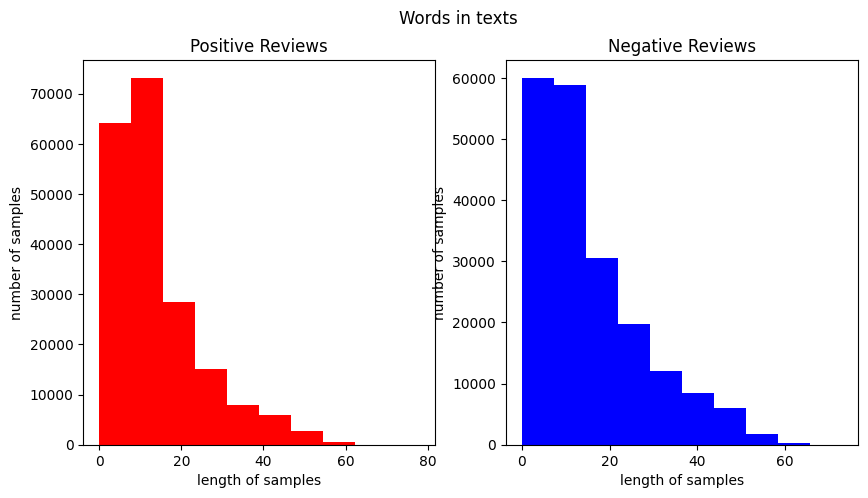

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [14]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(395536,) (395536,) (99378,) (99378,)


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 73062
등장 빈도가 1번 이하인 희귀 단어의 수: 27125
단어 집합에서 희귀 단어의 비율: 37.126002573157045
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.46524280357285897
단어 집합의 크기 : 45939


In [41]:
vocab_size

45939

In [16]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 14.740223393066623


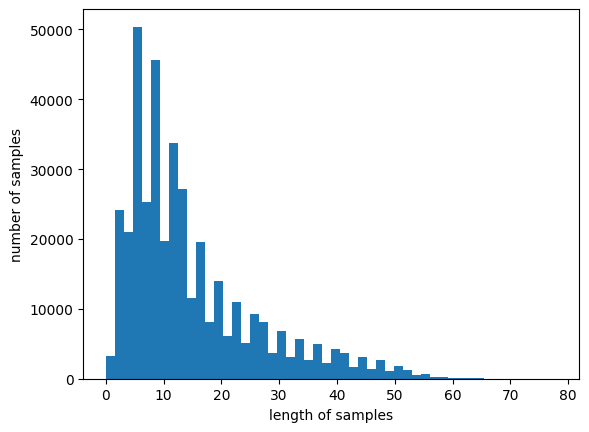

In [17]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [19]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [20]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [25]:
# from tensorflow.keras.layers import Embedding, Dense, GRU
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# embedding_dim = 100
# hidden_units = 128

# # tfa.metrics.F1Score()

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim))
# model.add(GRU(hidden_units))
# model.add(Dense(1, activation='sigmoid'))


# precision = tf.keras.metrics.Precision(name='precision')
# recall = tf.keras.metrics.Recall(name='recall')

# # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',precision,recall, tfa.metrics.F1Score(name='f1_score', num_classes=1)])
# history = model.fit(X_train, y_train, epochs=50, callbacks=[ mc], batch_size=64, validation_split=0.2)

In [26]:
MODEL_DIR = './model_loss'
if not os.path.exists(MODEL_DIR): 
    os.mkdir(MODEL_DIR)
modelpath = './model_loss/{epoch:02d}-{val_loss:.5f}.hdf5'
checkpointer_loss = ModelCheckpoint(
    filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True
)

MODEL_DIR = './model_acc'
if not os.path.exists(MODEL_DIR): 
    os.mkdir(MODEL_DIR)
modelpath = './model_acc/{epoch:02d}-{val_acc:.5f}.hdf5'
checkpointer_acc = ModelCheckpoint(
    filepath=modelpath, monitor='val_acc', verbose=1, save_best_only=True
)

In [28]:
embedding_dim = 100
hidden_units = 128

# tfa.metrics.F1Score()

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(1, activation='sigmoid'))


precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',precision,recall, tfa.metrics.F1Score(name='f1_score', num_classes=1)])
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=1), 'acc', precision, recall,])
history2 = model.fit(X_train, y_train, epochs=50, callbacks=[checkpointer_acc,checkpointer_loss, es ], batch_size=32, validation_data=[X_test, y_test])

Epoch 1/50
12360/12361 [============================>.] - ETA: 0s - loss: 0.3474 - f1_score: 0.6668 - acc: 0.8473 - precision: 0.8538 - recall: 0.8382
Epoch 1: val_acc improved from -inf to 0.86737, saving model to ./model_acc\01-0.86737.hdf5

Epoch 1: val_loss improved from inf to 0.30974, saving model to ./model_loss\01-0.30974.hdf5
12361/12361 [==============================] - 363s 28ms/step - loss: 0.3474 - f1_score: 0.6668 - acc: 0.8473 - precision: 0.8538 - recall: 0.8382 - val_loss: 0.3097 - val_f1_score: 0.6668 - val_acc: 0.8674 - val_precision: 0.8896 - val_recall: 0.8389
Epoch 2/50
12360/12361 [============================>.] - ETA: 0s - loss: 0.2753 - f1_score: 0.6668 - acc: 0.8856 - precision: 0.8893 - recall: 0.8809
Epoch 2: val_acc improved from 0.86737 to 0.87113, saving model to ./model_acc\02-0.87113.hdf5

Epoch 2: val_loss improved from 0.30974 to 0.30724, saving model to ./model_loss\02-0.30724.hdf5
12361/12361 [==============================] - 217s 18ms/step - los

In [71]:
loaded_model = load_model('./model_acc/02-0.87113.hdf5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

3106/3106 [==============================] - 77s 24ms/step - loss: 0.3072 - f1_score: 0.6668 - acc: 0.8711 - precision: 0.8715 - recall: 0.8707

 테스트 정확도: 0.8711


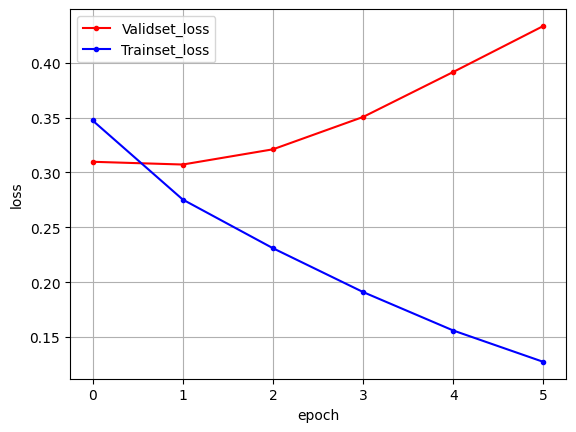

In [108]:
y_vloss = history2.history['val_loss']
y_loss = history2.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Validset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

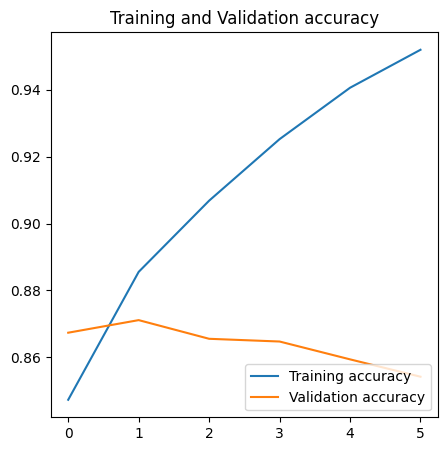

In [76]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
x_len = np.arange(len(y_loss))
plt.figure(figsize=(5,5))
plt.plot(x_len, acc,label='Training accuracy')
plt.plot(x_len, val_acc,label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')
plt.show()

In [ ]:
x_test

In [57]:
y_test

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

---

In [84]:
result = loaded_model.predict(X_test)
result = np.where(result >= 0.5, 1 , 0 )

3106/3106 [==============================] - 64s 21ms/step


In [85]:
cm = confusion_matrix(y_test, result)
print("훈련용 데이터 오차행렬:\n", cm)

훈련용 데이터 오차행렬:
 [[43296  6381]
 [ 6426 43275]]


Text(50.722222222222214, 0.5, 'Truth')

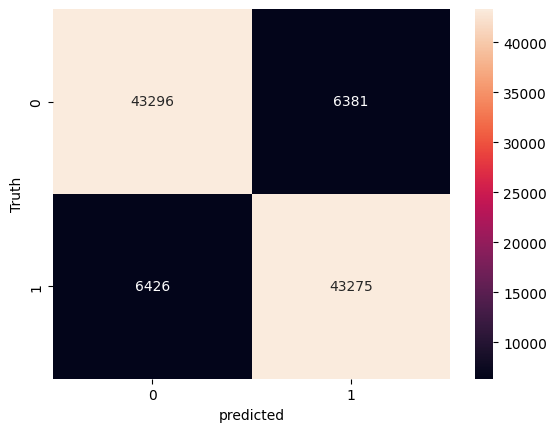

In [86]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')

In [ ]:
cm = confusion_matrix(y_test, result, normalize="all")
cm

In [79]:
print("훈련용 데이터 분류예측 리포트:\n", classification_report(y_test, result))

3106/3106 [==============================] - 64s 21ms/step
훈련용 데이터 오차행렬:
 [[43296  6381]
 [ 6426 43275]]
훈련용 데이터 분류예측 리포트:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87     49677
           1       0.87      0.87      0.87     49701

    accuracy                           0.87     99378
   macro avg       0.87      0.87      0.87     99378
weighted avg       0.87      0.87      0.87     99378



---

In [88]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [107]:
sentiment_predict('''신림 칼부림 꿀잼''')

1/1 [==============================] - 0s 46ms/step
96.39% 확률로 긍정 리뷰입니다.
